In [58]:
import pandas as pd 
import numpy as np 
import pybaseball as pyball
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

pd.set_option('display.max_columns', None)  # Show all columns


### THE GRAPHS 

In this notebook I want to mess around with different ways to present a pitchers aresenal. My goal with these visualizations is to get a better understanding of what a pitcher is up there throwing. 

We need a player to experiment on, when not Zach Eflin, the starting pitcher for the Baltimore Orioles during the BlueJays 2025 home opener. 

In [23]:
#The data 

#Set whatever date range you want!! 
start = '2024-03-20'
end = '2024-9-30'

#Player Name
last = 'Eflin'
first = 'Zach'

#Get Player ID
id = int(pyball.playerid_lookup(last, first)['key_mlbam'].values[0])

pbp_data = pyball.statcast_pitcher(start, end, id)
php_data = pbp_data[pbp_data['game_type'] == 'R']

pbp_data.head(5)

Gathering Player Data


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,fielder_2,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length,estimated_slg_using_speedangle,delta_pitcher_run_exp,hyper_speed,home_score_diff,bat_score_diff,home_win_exp,bat_win_exp,age_pit_legacy,age_bat_legacy,age_pit,age_bat,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle
0,FC,2024-09-25,88.9,-2.37,5.80,"Eflin, Zach",669224,621107,walk,ball,NaN,NaN,NaN,NaN,11.0,Austin Wells walks. Aaron Judge to 2nd.,R,L,R,NYY,BAL,B,NaN,NaN,3,1,2024,0.11,0.67,-1.08,3.58,NaN,NaN,592450.0,2,5,Bot,NaN,NaN,NaN,NaN,NaN,NaN,2.971185,-129.589476,-0.845252,0.639171,25.182412,-24.653830,3.47,1.60,NaN,NaN,NaN,89.8,2189.0,6.6,745690,543510,663624,676059,602104,683002,681297,656775,623993,53.88,NaN,0.689131,0.7,1.0,0.0,0.0,NaN,50,5,Cutter,3,8,3,8,8,3,3,8,Infield shade,Standard,210.0,0.011,0.152,NaN,NaN,NaN,-0.152,NaN,-5,-5,0.053,0.053,30,24,30,25,3,2,6.0,1.0,7.0,1.0,2.19,-0.11,0.11,25.7
1,CH,2024-09-25,87.9,-2.24,5.85,"Eflin, Zach",669224,621107,NaN,ball,NaN,NaN,NaN,NaN,14.0,Austin Wells walks. Aaron Judge to 2nd.,R,L,R,NYY,BAL,B,NaN,NaN,2,1,2024,-1.34,0.13,0.43,1.03,NaN,NaN,592450.0,2,5,Bot,NaN,NaN,NaN,NaN,NaN,NaN,9.329778,-127.670315,-5.897741,-16.583509,26.030741,-29.678778,3.47,1.57,NaN,NaN,NaN,88.8,1892.0,6.9,745690,543510,663624,676059,602104,683002,681297,656775,623993,53.55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50,4,Changeup,3,8,3,8,8,3,3,8,Infield shade,Standard,244.0,0.000,0.078,NaN,NaN,NaN,-0.078,NaN,-5,-5,0.053,0.053,30,24,30,25,3,2,6.0,1.0,7.0,1.0,2.83,1.34,-1.34,29.4
2,FF,2024-09-25,91.4,-2.29,5.79,"Eflin, Zach",669224,621107,NaN,ball,NaN,NaN,NaN,NaN,11.0,Austin Wells walks. Aaron Judge to 2nd.,R,L,R,NYY,BAL,B,NaN,NaN,1,1,2024,-0.66,1.12,-0.94,2.91,NaN,NaN,592450.0,2,5,Bot,NaN,NaN,NaN,NaN,NaN,NaN,4.871336,-132.952630,-3.776810,-8.836707,29.827299,-18.357870,3.55,1.68,NaN,NaN,NaN,92.0,2172.0,6.8,745690,543510,663624,676059,602104,683002,681297,656775,623993,53.73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50,3,4-Seam Fastball,3,8,3,8,8,3,3,8,Infield shade,Standard,231.0,0.000,0.050,NaN,NaN,NaN,-0.050,NaN,-5,-5,0.053,0.053,30,24,30,25,3,2,6.0,1.0,7.0,1.0,1.63,0.66,-0.66,25.2
3,FC,2024-09-25,88.4,-2.29,5.75,"Eflin, Zach",669224,621107,NaN,swinging_strike,NaN,NaN,NaN,NaN,1.0,Austin Wells walks. Aaron Judge to 2nd.,R,L,R,NYY,BAL,S,NaN,NaN,1,0,2024,0.00,0.70,-0.34,3.20,NaN,NaN,592450.0,2,5,Bot,NaN,NaN,NaN,NaN,NaN,NaN,4.774309,-128.767122,-1.638702,-0.929811,25.159661,-24.214937,3.47,1.65,NaN,NaN,NaN,89.4,2155.0,6.7,745690,543510,663624,676059,602104,683002,681297,656775,623993,53.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50,2,Cutter,3,8,3,8,8,3,3,8,Infield shade,Standard,209.0,0.000,-0.048,72.9,6.5,NaN,0.048,NaN,-5,-5,0.053,0.053,30,24,30,25,3,2,6.0,1.0,7.0,1.0,2.20,0.00,0.00,26.3
4,FC,2024-09-25,88.8,-2.43,5.79,"Eflin, Zach",669224,621107,NaN,ball,NaN,NaN,NaN,NaN,11.0,Austin Wells walks. Aaron Judge to 2nd.,R,L,R,NYY,BAL,B,NaN,NaN,0,

In [27]:
#Pitch distribution
pitch_counts = pbp_data['pitch_name'].value_counts().to_dict()

pitch_counts_LHB = pbp_data[pbp_data['stand'] == 'L']
pitch_counts_LHB = pitch_counts_LHB['pitch_name'].value_counts().to_dict()

pitch_counts_RHB = pbp_data[pbp_data['stand'] == 'R']
pitch_counts_RHB = pitch_counts_RHB['pitch_name'].value_counts().to_dict()

In [19]:
pitch_counts

{'Sinker': 706,
 'Cutter': 691,
 'Curveball': 461,
 'Sweeper': 231,
 '4-Seam Fastball': 205,
 'Changeup': 148,
 'Slider': 5}

In [25]:
pitch_counts_LHB

{'Cutter': 453,
 'Sinker': 242,
 'Curveball': 223,
 'Changeup': 140,
 '4-Seam Fastball': 124,
 'Sweeper': 39}

In [28]:
pitch_counts_RHB

{'Sinker': 464,
 'Cutter': 238,
 'Curveball': 238,
 'Sweeper': 192,
 '4-Seam Fastball': 81,
 'Changeup': 8,
 'Slider': 5}

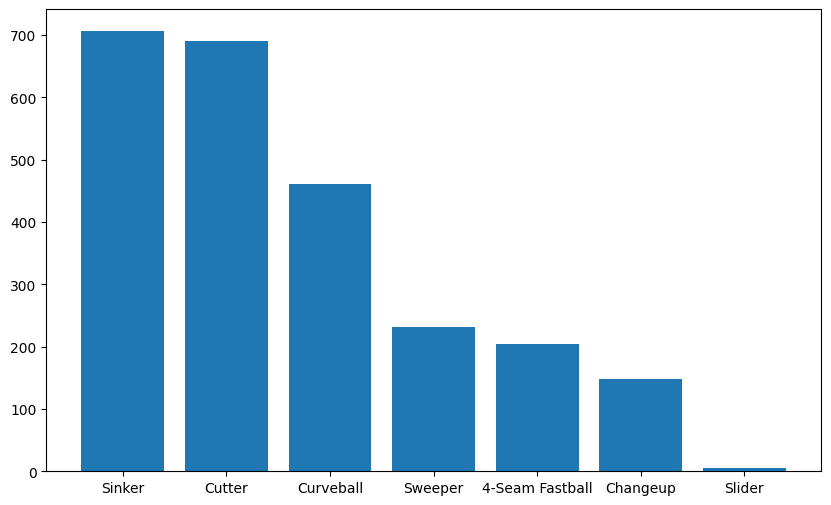

In [ ]:
#BAR CHART

plt.figure(figsize=(10, 6))
plt.bar(pitch_counts.keys(), pitch_counts.values())





plt.show()

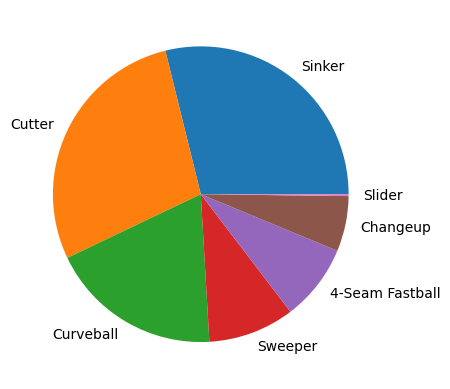

In [21]:
#PIE CHART 

plt.pie(pitch_counts.values(), labels = pitch_counts.keys())


plt.show()





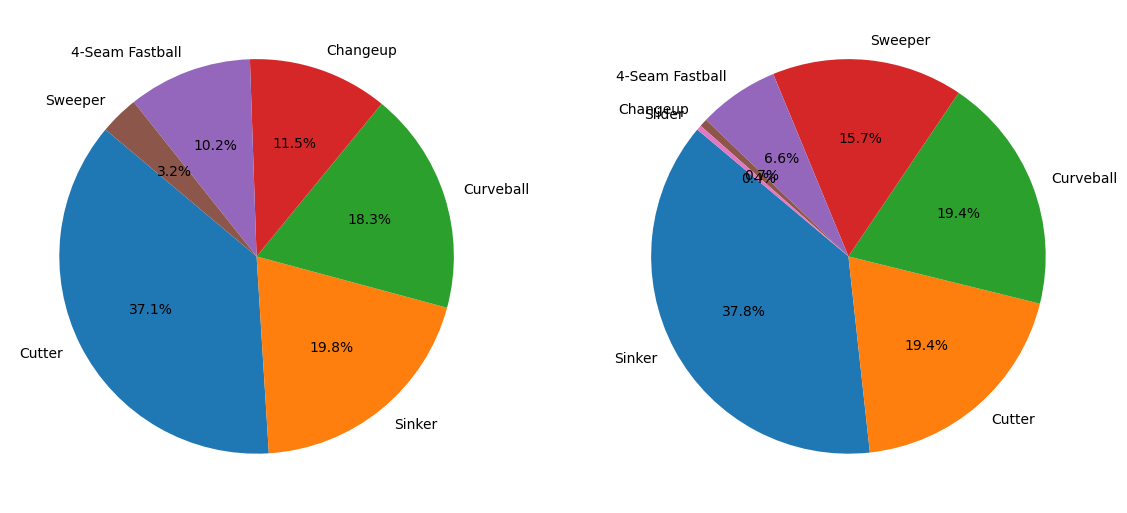

In [ ]:
#Compare RHB vs LHB 

fig, axes = plt.subplots(1,2, figsize=(14,7))

axes[0].pie(
    pitch_counts_LHB.values(),
    labels = pitch_counts_LHB.keys(),
    autopct = '%1.1f%%',
    startangle = 140
)

axes[1].pie(
    pitch_counts_RHB.values(),
    labels = pitch_counts_RHB.keys(),
    autopct = '%1.1f%%',
    startangle = 140
)


plt.show()
#kinda sloppy and annoying to makes changes twice, lets see if we can use a loop to make the code cleaner.


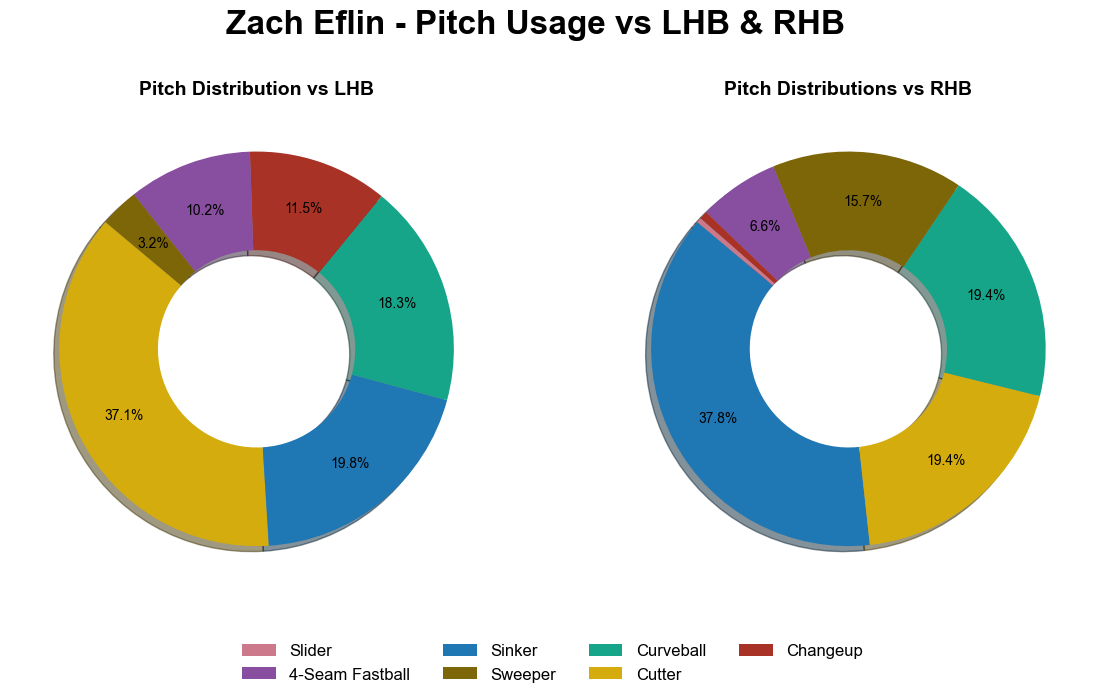

In [137]:
batter_splits = [pitch_counts_LHB, pitch_counts_RHB]
titles = ['Pitch Distribution vs LHB', 'Pitch Distributions vs RHB']

#Pitch colours need to be consistent so the pies will be easier to read and compare 
pitch_colors = {
    'Sinker': '#1f77b4',       
    'Cutter': '#d4ac0d',      
    'Curveball': '#17a589',    
    'Sweeper': '#7d6608',     
    '4-Seam Fastball': '#884ea0',  
    'Changeup': '#a93226',    
    'Slider': '#CC7A8B',       
    'Other': '#7f7f7f'         
}
#change font for fun
plt.rcParams['font.family'] = 'Arial'


def autopct_threshold(pct, threshold=2):
    return f'{pct:.1f}%' if pct > threshold else ''

fig, axes = plt.subplots(1,2, figsize = (14,7))

for ax, pitch_data, title in zip(axes, batter_splits, titles):

    labels = list(pitch_data.keys())
    colours = [pitch_colors.get(pitch, pitch_colors['Other']) for pitch in labels]

    ax.pie(
        pitch_data.values(), 
        startangle = 140,
        autopct =lambda pct: autopct_threshold(pct, threshold=3),
        labeldistance=1.1,
        colors = colours,
        pctdistance = 0.75,
        wedgeprops=dict(width=0.5), 
        shadow = True   
    )
    ax.set_title(title, fontsize = 14, fontweight='bold')


# Get all unique pitch types used across both LHB and RHB
all_pitches = set(pitch_counts_LHB.keys()) | set(pitch_counts_RHB.keys())
legend_elements = [
    Patch(facecolor = pitch_colors.get(pitch, pitch_colors['Other']), label=pitch)
    for pitch in all_pitches
]

# Add the legend to the figure (not one of the axes)
fig.legend(
    handles = legend_elements,
    loc='lower center',  
    ncol = 4,              
    fontsize = 12,
    frameon = False
)

main_title = first + ' ' + last + ' - Pitch Usage vs LHB & RHB' 
fig.suptitle(main_title, fontsize = 24, fontweight = 'bold')
plt.show()
